In [1]:
%load_ext autoreload
%autoreload 2

# Base Notebook to re-create figures of _

This notebook is the base notebook for 10X's Xenium brain showcase tissue sample. It runs the standard ovrlpy pipeline and saves the results to be used in further analysis.

In [2]:
from pathlib import Path

data_folder_path = Path("/dh-projects/ag-ishaque/raw_data/tiesmeys-ovrlpy/Xenium-brain-2024/replicate1")


### Data loader:

In [3]:
import pandas as  pd

coordinate_df = pd.read_parquet(data_folder_path/"transcripts.parquet")
coordinate_df["feature_name"]=coordinate_df.feature_name.str.decode("utf-8")

# remove dummy molecules:
dummy_mask = (coordinate_df.feature_name.str.contains('BLANK') | coordinate_df.feature_name.str.contains('NegControl'))
coordinate_df = coordinate_df[~dummy_mask]

# format columns:
coordinate_df = coordinate_df[['x_location','y_location','z_location','feature_name','cell_id','overlaps_nucleus','qv']]
coordinate_df.columns = ['x','y','z','gene','cell_id','overlaps_nucleus','qv']
coordinate_df['gene'] = coordinate_df['gene'].astype("category")

print(f"Number of cells: {coordinate_df.cell_id.nunique()}",f"Number of genes: {coordinate_df.gene.nunique()}",f"Number of molecules: {coordinate_df.shape[0]}",sep="\n")

genes = coordinate_df.gene.cat.categories

Number of cells: 162034
Number of genes: 248
Number of molecules: 62384369


In [4]:
import numpy as np
import matplotlib.pyplot as plt

signatures_ = pd.read_csv('/dh-projects/ag-ishaque/raw_data/Xenium-benchmark/scRNAseq/trimmed_means.csv',index_col=0)

signatures_ = signatures_.T.groupby(lambda x: x.split('_')[1].split(' ')[0].split('-')[0]).apply(lambda x: x.mean(0)).T

signatures = pd.DataFrame(index=genes,columns=signatures_.columns)
signatures = signatures.fillna(0.0)

for gene in genes:
    if gene in signatures_.index:
        signatures.loc[gene] = signatures_.loc[gene]

del signatures_ 

signatures.columns=signatures.columns.str.replace('/','-')



/tmp/ipykernel_448066/3420117031.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  signatures = signatures.fillna(0.0)


In [5]:
import anndata as ad

adata = ad.read_mtx(data_folder_path/"cell_feature_matrix/matrix.mtx").T
adata.var = pd.read_csv(data_folder_path/"cell_feature_matrix/features.tsv", header=None, index_col=1, names=["gene_id", "gene", "feature_type"],sep="\t")
obs_dict = pd.read_parquet(data_folder_path/"cells.parquet",)#.set_index("cell_id")
for c in obs_dict.columns:
    adata.obs[c] = obs_dict[c].values
adata.obs.set_index("cell_id",inplace=True)
adata.obs.index = adata.obs.index.astype("category")
adata.obs[['x_centroid','y_centroid']]

# Filter out empty cells:
# adata = adata[adata.X.sum(axis=1)>50]

,x_centroid,y_centroid
cell_id,,
1,1557.532239,2528.022437
2,1560.669312,2543.632678
3,1570.462885,2530.810461
4,1573.927734,2546.454529
5,1581.344379,2557.024951
...,...,...
162029,8310.558740,4345.094580
162030,8316.195801,4321.954077
162031,8323.133594,4271.474121


In [6]:
# from shapely.geometry import Polygon as shapely_Polygon
# import tqdm
# import rasterio
# from rasterio.features import rasterize

# um_per_pixel=1

# cell_boundaries = pd.read_parquet(data_folder_path/"cell_boundaries.parquet")
# nucleus_boundaries = pd.read_parquet(data_folder_path/"nucleus_boundaries.parquet")
# cell_boundaries[['vertex_x','vertex_y']]/=um_per_pixel
# nucleus_boundaries[['vertex_x','vertex_y']]/=um_per_pixel

# max_size = [0,0]

# polygons = []
# for i, cell_id in tqdm.tqdm(enumerate(adata.obs.index),total = len(adata.obs)):
#     coords = nucleus_boundaries[nucleus_boundaries.cell_id==cell_id][['vertex_x','vertex_y']] 
#     # coords = cell_boundaries[cell_boundaries.cell_id==cell_id][['vertex_x','vertex_y']] 
    
#     max_size[0] = max(max_size[0],coords['vertex_x'].max())
#     max_size[1] = max(max_size[1],coords['vertex_y'].max())
    
#     polygons.append((shapely_Polygon(coords.values),cell_id))
    
# segmentation_map_ = rasterize(polygons, out_shape=np.array(max_size).astype(int)+1, fill=np.nan, all_touched=True, dtype=float, ).T

/tmp/ipykernel_448066/4106872359.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_marker_counts = gene_group_df.groupby("group").apply(lambda x: np.array(adata.X[:,x.idx].sum(1)).flatten())


<Axes: ylabel='Frequency'>

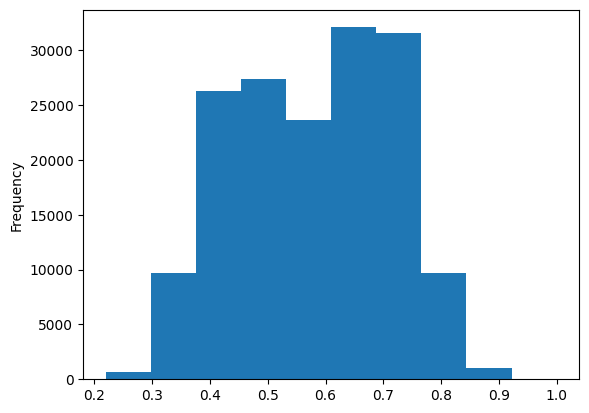

In [7]:
import numpy as np

gene_group_df = pd.read_csv(data_folder_path/"Xenium_V1_FF_Mouse_Brain_MultiSection_Input_gene_groups.csv",header=0,index_col=0,usecols=[0,1])
gene_group_df['idx']=np.arange(len(gene_group_df))

group_marker_counts = gene_group_df.groupby("group").apply(lambda x: np.array(adata.X[:,x.idx].sum(1)).flatten())
group_marker_counts = pd.DataFrame(group_marker_counts.values.tolist(),index=group_marker_counts.index,columns=adata.obs.index)

assignments_by_marker_counts = group_marker_counts.idxmax(axis=0)
marker_purities = np.array([group_marker_counts.at[idx, col] for idx, col in zip(assignments_by_marker_counts.values, assignments_by_marker_counts.index)])/group_marker_counts.sum(0)

marker_purities

adata.obs["assignments_by_marker_counts"] = assignments_by_marker_counts
adata.obs["marker_purities"] = marker_purities

adata.obs.marker_purities.plot.hist()

#### Create count matrices for use in mapmycells:

In [8]:
import tqdm

bottom_count_mtx = pd.DataFrame(index=coordinate_df.gene.cat.categories,columns=adata.obs.index,dtype=int).fillna(0)
top_count_mtx = pd.DataFrame(index=coordinate_df.gene.cat.categories,columns=adata.obs.index,dtype=int).fillna(0)

coordinate_df['z_delim'] = coordinate_df[['cell_id','z']].groupby('cell_id').transform("mean")

bottom_counts = coordinate_df[(coordinate_df.z<coordinate_df.z_delim)&(coordinate_df.overlaps_nucleus==1)].groupby("gene").apply(lambda x:x.cell_id.value_counts())
top_counts = coordinate_df[(coordinate_df.z>coordinate_df.z_delim)&(coordinate_df.overlaps_nucleus==1)].groupby("gene").apply(lambda x:x.cell_id.value_counts())


for i,g in tqdm.tqdm(enumerate(coordinate_df.gene.cat.categories),total=len(coordinate_df.gene.cat.categories)):
    # print(bottom_counts.loc[c])
    bottom_count_mtx.loc[g] = bottom_counts[g]
    top_count_mtx.loc[g] = top_counts[g]
    
bottom_count_mtx.fillna(0,inplace=True)
top_count_mtx.fillna(0,inplace=True)
    
# sns.heatmap(top_count_mtx,cmap='viridis',vmax=10)

import anndata
anndata.AnnData(bottom_count_mtx.T).write_h5ad("../ovrlpy_24/publication/xenium-brain/top-bottom-qc/bottom_count_mtx_nuclei.h5ad")
anndata.AnnData(top_count_mtx.T).write_h5ad("../ovrlpy_24/publication/xenium-brain/top-bottom-qc/top_count_mtx_nuclei.h5ad")

/tmp/ipykernel_448066/1263139696.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bottom_counts = coordinate_df[(coordinate_df.z<coordinate_df.z_delim)&(coordinate_df.overlaps_nucleus==1)].groupby("gene").apply(lambda x:x.cell_id.value_counts())
/tmp/ipykernel_448066/1263139696.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bottom_counts = coordinate_df[(coordinate_df.z<coordinate_df.z_delim)&(coordinate_df.overlaps_nucleus==1)].groupby("gene").apply(lambda x:x.cell_id.value_counts())
/tmp/ipykernel_

### Create a publishable HD figure of the colorized tissue:

In [9]:
import os


def load_mapmycells_csv(region='whole'):
    files = os.listdir(f"publication/xenium-brain/top-bottom-qc/mapmycells/{region}/")
    csv = sorted([f for f in files if f.endswith(".csv")])[-1]
    
    mapmycells_df = pd.read_csv(f"publication/xenium-brain/top-bottom-qc/mapmycells/{region}/{csv}",index_col=0,skiprows=4)
    
    return mapmycells_df

#### Upload mapmycells cell type assignments:

(34.0, 0.0)

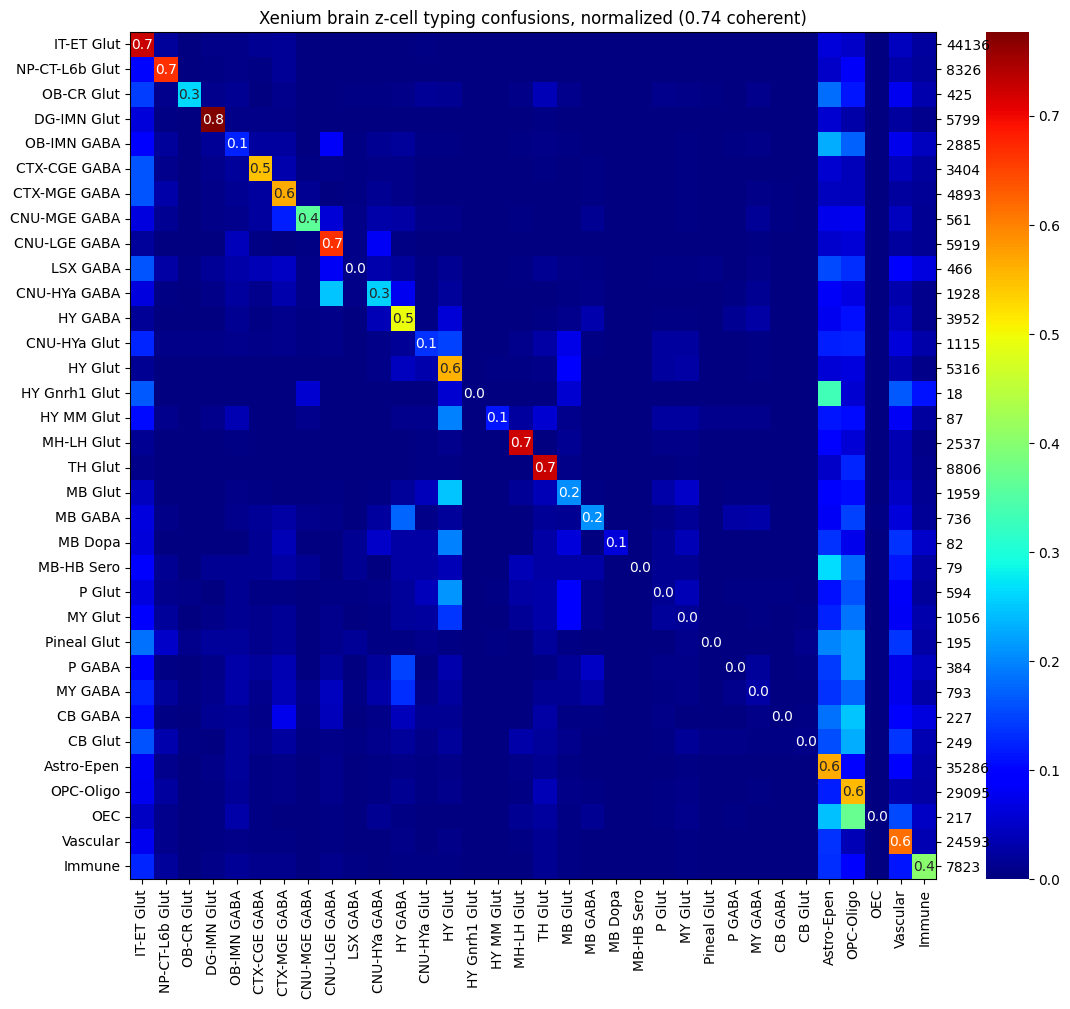

In [10]:
import seaborn as sns

# Correlation:
mapmycells_df_bottom = load_mapmycells_csv('bottom')
mapmycells_df_top = load_mapmycells_csv('top')

# ratio of coherently predicted cell types across the vertical demarcation:
global_prediction_coherence =(mapmycells_df_top.class_name.astype(str)==mapmycells_df_bottom.class_name.astype(str)).mean()

mapmycells_df_top['family_name'] = mapmycells_df_top.class_name.str.split(' ').str[-1].astype('category')
mapmycells_df_bottom['family_name'] = mapmycells_df_bottom.class_name.str.split(' ').str[-1].astype('category')
all_classes = sorted(list(set(mapmycells_df_top['class_name'].unique()).union(set(mapmycells_df_bottom['class_name'].unique()))))

(mapmycells_df_top == mapmycells_df_bottom).mean()

celltype_confusions = pd.DataFrame(index=all_classes,columns=all_classes).astype(float)
celltype_crossconfusions = celltype_confusions.copy()

counts = pd.Series(index=all_classes,dtype=int)
annotations = pd.DataFrame(index=all_classes,columns=all_classes).astype(str)
annotations[:] = ''

for i in celltype_confusions.index:
    for j in celltype_confusions.columns:
        celltype_confusions.loc[i,j] = ((mapmycells_df_top['class_name']==i)&(mapmycells_df_bottom['class_name']==j)).sum()
        if i==j:
            celltype_crossconfusions.loc[i,j]=np.nan
            continue
        celltype_crossconfusions.loc[i,j] = celltype_confusions.loc[i,j]
        
    counts[i] = ((mapmycells_df_top['class_name']==i)|(mapmycells_df_bottom['class_name']==i)).sum()


celltype_confusions = celltype_confusions+celltype_confusions.T
celltype_confusions /= np.eye(len(celltype_confusions))+1
celltype_confusions.index = celltype_confusions.index.str.split(' ').str[1:].str.join(' ')
celltype_confusions.columns = celltype_confusions.columns.str.split(' ').str[1:].str.join(' ')

celltype_confusions/=celltype_confusions.sum(1)
celltype_confusions = celltype_confusions.T


celltype_crossconfusions = celltype_crossconfusions+celltype_crossconfusions.T
celltype_crossconfusions.index = celltype_crossconfusions.index.str.split(' ').str[1:].str.join(' ')
celltype_crossconfusions.columns = celltype_crossconfusions.columns.str.split(' ').str[1:].str.join(' ')

celltype_crossconfusions/=celltype_crossconfusions.sum(1)
celltype_crossconfusions = celltype_crossconfusions.T

for i in range(len(celltype_confusions.index)):
    annotations.iloc[i,i] = f"{celltype_confusions.iloc[i,i]:.1f}"        
    
fig = plt.figure(figsize=(13,11))
ax = plt.subplot(111)
sns.heatmap(celltype_confusions,annot=annotations,ax=ax,cmap='jet',fmt='')
plt.title(f"Xenium brain z-cell typing confusions, normalized ({global_prediction_coherence:.2f} coherent)")

# Set the secondary y-axis ticks and labels
ax2 = ax.twinx()
ax2.set_yticks(ax.get_yticks())
ax2.set_yticklabels(counts.astype(int).astype(str))
ax2.set_ylim(ax.get_ylim())

# ax = plt.subplot(122)
# sns.heatmap(celltype_crossconfusions,ax=ax,cmap='jet')
# plt.title('vertical cell typing cross-confusion matrix, normalized')


# # Set the secondary y-axis ticks and labels
# ax2 = ax.twinx()
# ax2.set_yticks(ax.get_yticks())
# ax2.set_yticklabels(counts.astype(int).astype(str))
# ax2.set_ylim(ax.get_ylim())


(6.0, 0.0)

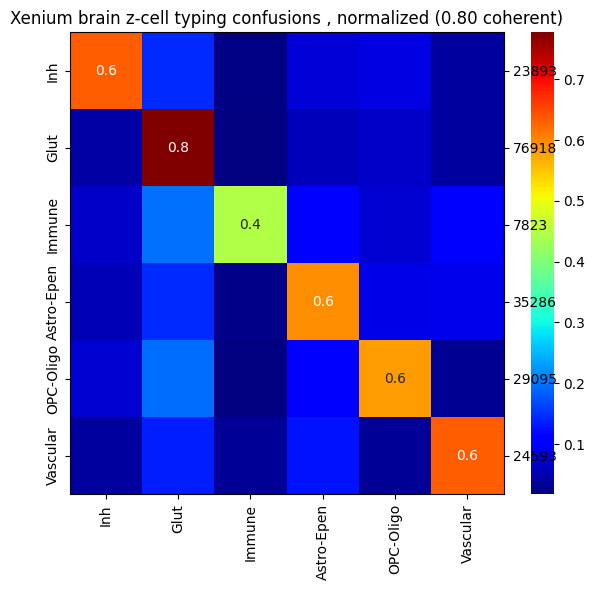

In [11]:

mapmycells_df_top['family_name'] = mapmycells_df_top.class_name.str.split(' ').str[-1]#.astype('category')
mapmycells_df_bottom['family_name'] = mapmycells_df_bottom.class_name.str.split(' ').str[-1]#.astype('category')
# all_classes = sorted(list(set(mapmycells_df_top['family_name'].unique()).union(set(mapmycells_df_bottom['family_name'].unique()))))
all_classes = 'Inh','Glut','Immune','Astro-Epen','OPC-Oligo','Vascular'
inh_classes = 'GABA','Sero'#,'Dopa'
mapmycells_df_bottom.loc[mapmycells_df_bottom['family_name'].isin(inh_classes),'family_name'] = 'Inh'
mapmycells_df_top.loc[mapmycells_df_top['family_name'].isin(inh_classes),'family_name'] = 'Inh'

global_prediction_coherence =(mapmycells_df_top.family_name.astype(str)==mapmycells_df_bottom.family_name.astype(str))[adata.obs.total_counts>100].mean()

(mapmycells_df_top == mapmycells_df_bottom).mean()

celltype_confusions = pd.DataFrame(index=all_classes,columns=all_classes).astype(float)
celltype_crossconfusions = celltype_confusions.copy()

counts = pd.Series(index=all_classes,dtype=int)
annotations = pd.DataFrame(index=all_classes,columns=all_classes).astype(str)
annotations[:] = ''

for i in celltype_confusions.index:
    for j in celltype_confusions.columns:
        celltype_confusions.loc[i,j] = (((mapmycells_df_top['family_name']==i)&(mapmycells_df_bottom['family_name']==j))[adata.obs.total_counts>100]).sum()
        if i==j:
            celltype_crossconfusions.loc[i,j]=np.nan
            continue
        celltype_crossconfusions.loc[i,j] = celltype_confusions.loc[i,j]
        
    counts[i] = ((mapmycells_df_top['family_name']==i)|(mapmycells_df_bottom['family_name']==i)).sum()

celltype_confusions = celltype_confusions+celltype_confusions.T
celltype_confusions /= np.eye(len(celltype_confusions))+1
# celltype_confusions.index = celltype_confusions.index.str.split(' ').str[1:].str.join(' ')
# celltype_confusions.columns = celltype_confusions.columns.str.split(' ').str[1:].str.join(' ')

celltype_confusions/=celltype_confusions.sum(1)
celltype_confusions = celltype_confusions.T

celltype_crossconfusions = celltype_crossconfusions+celltype_crossconfusions.T
celltype_crossconfusions.index = celltype_crossconfusions.index.str.split(' ').str[1:].str.join(' ')
celltype_crossconfusions.columns = celltype_crossconfusions.columns.str.split(' ').str[1:].str.join(' ')

celltype_crossconfusions/=celltype_crossconfusions.sum(1)
celltype_crossconfusions = celltype_crossconfusions.T

for i in range(len(celltype_confusions.index)):
    annotations.iloc[i,i] = f"{celltype_confusions.iloc[i,i]:.1f}"        
    
fig = plt.figure(figsize=(7,6))
ax = plt.subplot(111)
sns.heatmap(celltype_confusions,annot=annotations,ax=ax,cmap='jet',fmt='')
plt.title(f"Xenium brain z-cell typing confusions , normalized ({global_prediction_coherence:.2f} coherent)")

# Set the secondary y-axis ticks and labels
ax2 = ax.twinx()
ax2.set_yticks(ax.get_yticks())
ax2.set_yticklabels(counts.astype(int).astype(str))
ax2.set_ylim(ax.get_ylim())





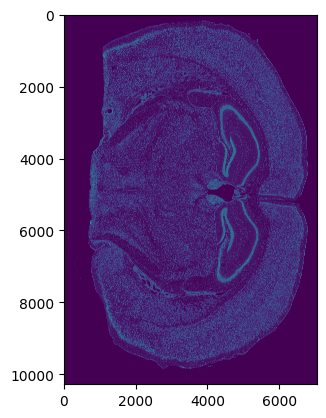

In [21]:
import ovrlpy

signal_ = ovrlpy._ssam2.kde_2d(coordinate_df[['x','y',]].values,bandwidth=1)

plt.imshow(signal_)

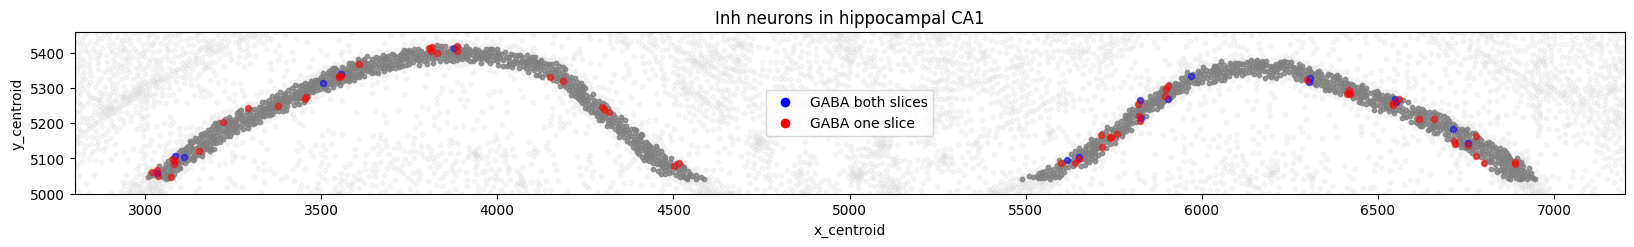

In [54]:
plt.figure(figsize=(20,5))
glial_classes = ['30 Astro-Epen', '33 Vascular', '31 OPC-Oligo', '34 Immune']


from scipy.ndimage import gaussian_filter

dense_map = gaussian_filter((gaussian_filter(signal_.T,10)>3).astype(float),13)>0.3
is_dense = (dense_map)[adata.obs.y_centroid.astype(int),adata.obs.x_centroid.astype(int)]
is_ca1 = is_dense&adata.obs.x_centroid.between(1400*2,3600*2)&adata.obs.y_centroid.between(2520*2,2730*2)

ax = plt.subplot(111)

adata.obs.plot.scatter(x='x_centroid',y='y_centroid',c='lightgrey',s=10,alpha=0.2,ax=ax)
adata.obs[is_ca1].plot.scatter(x='x_centroid',y='y_centroid',c='Grey',s=10,alpha=0.8,ax=ax)
adata.obs[is_ca1&((mapmycells_df_top.class_name.str.contains('GABA'))&(mapmycells_df_bottom.class_name.str.contains('GABA')))].plot.scatter(x='x_centroid',y='y_centroid',c='blue',s=20,alpha=0.5,ax=ax)
adata.obs[is_ca1&((mapmycells_df_top.class_name.str.contains('GABA'))^(mapmycells_df_bottom.class_name.str.contains('GABA')))].plot.scatter(x='x_centroid',y='y_centroid',c='red',s=20,alpha=0.5,ax=ax)
# adata.obs[is_ca1&((mapmycells_df_top.class_name.isin(glial_classes)))].plot.scatter(x='x_centroid',y='y_centroid',c='goldenrod',s=20,alpha=0.5,ax=ax)

ca1_inh = adata.obs[is_ca1&((mapmycells_df_top.class_name.str.contains('GABA'))|(mapmycells_df_bottom.class_name.str.contains('GABA')))]
 
plt.xlim(1400*2,3600*2)
plt.ylim(2500*2,2730*2)

plt.gca().set_aspect('equal', )
plt.title('Inh neurons in hippocampal CA1')

plt.legend([plt.scatter([],[],c='b'),plt.scatter([],[],c='r'), ],['GABA both slices','GABA one slice'],)


Text(0.5, 1.0, 'Xenium hippocampal z-cell typing confusions, normalized (0.16 non-glut coherent)')

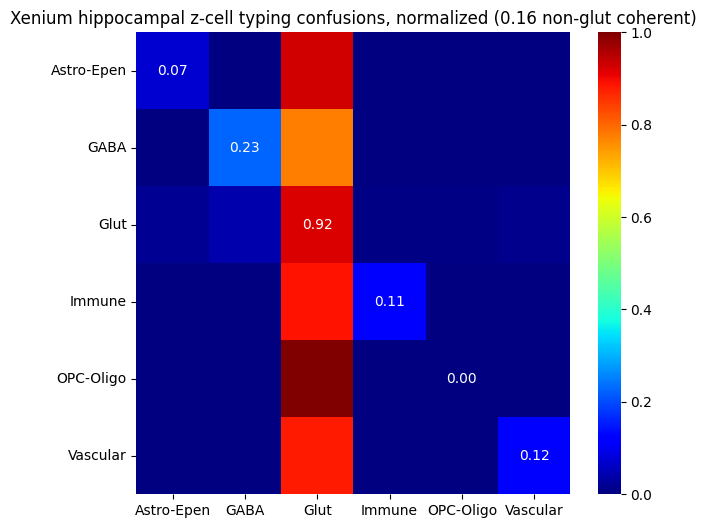

In [55]:

ca1_df_top = mapmycells_df_top[is_ca1].copy()
ca1_df_bottom = mapmycells_df_bottom[is_ca1].copy()

ca1_df_top['family_name'] = ca1_df_top.class_name.str.split(' ').str[-1].astype('str')
ca1_df_bottom['family_name'] = ca1_df_bottom.class_name.str.split(' ').str[-1].astype('str')

all_classes = sorted(list(set(ca1_df_top['family_name'].unique()).union(set(ca1_df_bottom['family_name'].unique()))))


global_prediction_coherence =(ca1_df_top.family_name.astype(str)==ca1_df_bottom.family_name.astype(str))[~((ca1_df_top.family_name=='Glut')&(ca1_df_bottom.family_name=='Glut'))].mean()

celltype_confusions = pd.DataFrame(index=all_classes,columns=all_classes).astype(float)
celltype_crossconfusions = celltype_confusions.copy()

counts = pd.Series(index=all_classes,dtype=int)
annotations = pd.DataFrame(index=all_classes,columns=all_classes).astype(str)
annotations[:] = ''

for i in celltype_confusions.index:
    for j in celltype_confusions.columns:
        celltype_confusions.loc[i,j] = ((ca1_df_top['family_name']==i)&(ca1_df_bottom['family_name']==j)).sum()
        if i==j:
            celltype_crossconfusions.loc[i,j]=np.nan
            continue
        celltype_crossconfusions.loc[i,j] = celltype_confusions.loc[i,j]
        
    counts[i] = ((ca1_df_top['family_name']==i)|(ca1_df_bottom['family_name']==i)).sum()

celltype_confusions = celltype_confusions+celltype_confusions.T
celltype_confusions /= np.eye(len(celltype_confusions))+1

celltype_confusions[:] = celltype_confusions/celltype_confusions.sum(1)
celltype_confusions = celltype_confusions.T


celltype_crossconfusions = celltype_crossconfusions+celltype_crossconfusions.T
celltype_crossconfusions.index = celltype_crossconfusions.index.str.split(' ').str[1:].str.join(' ')
celltype_crossconfusions.columns = celltype_crossconfusions.columns.str.split(' ').str[1:].str.join(' ')

celltype_crossconfusions/=celltype_crossconfusions.sum(1)
celltype_crossconfusions = celltype_crossconfusions.T

for i in range(len(celltype_confusions.index)):
    annotations.iloc[i,i] = f"{celltype_confusions.iloc[i,i]:.2f}"        
    
fig = plt.figure(figsize=(7,6))
ax = plt.subplot(111)
sns.heatmap(celltype_confusions,annot=annotations,ax=ax,cmap='jet',fmt='')
plt.yticks(rotation=0)
plt.title(f"Xenium hippocampal z-cell typing confusions, normalized ({global_prediction_coherence:.2f} non-glut coherent)")
